# Best Accuracy

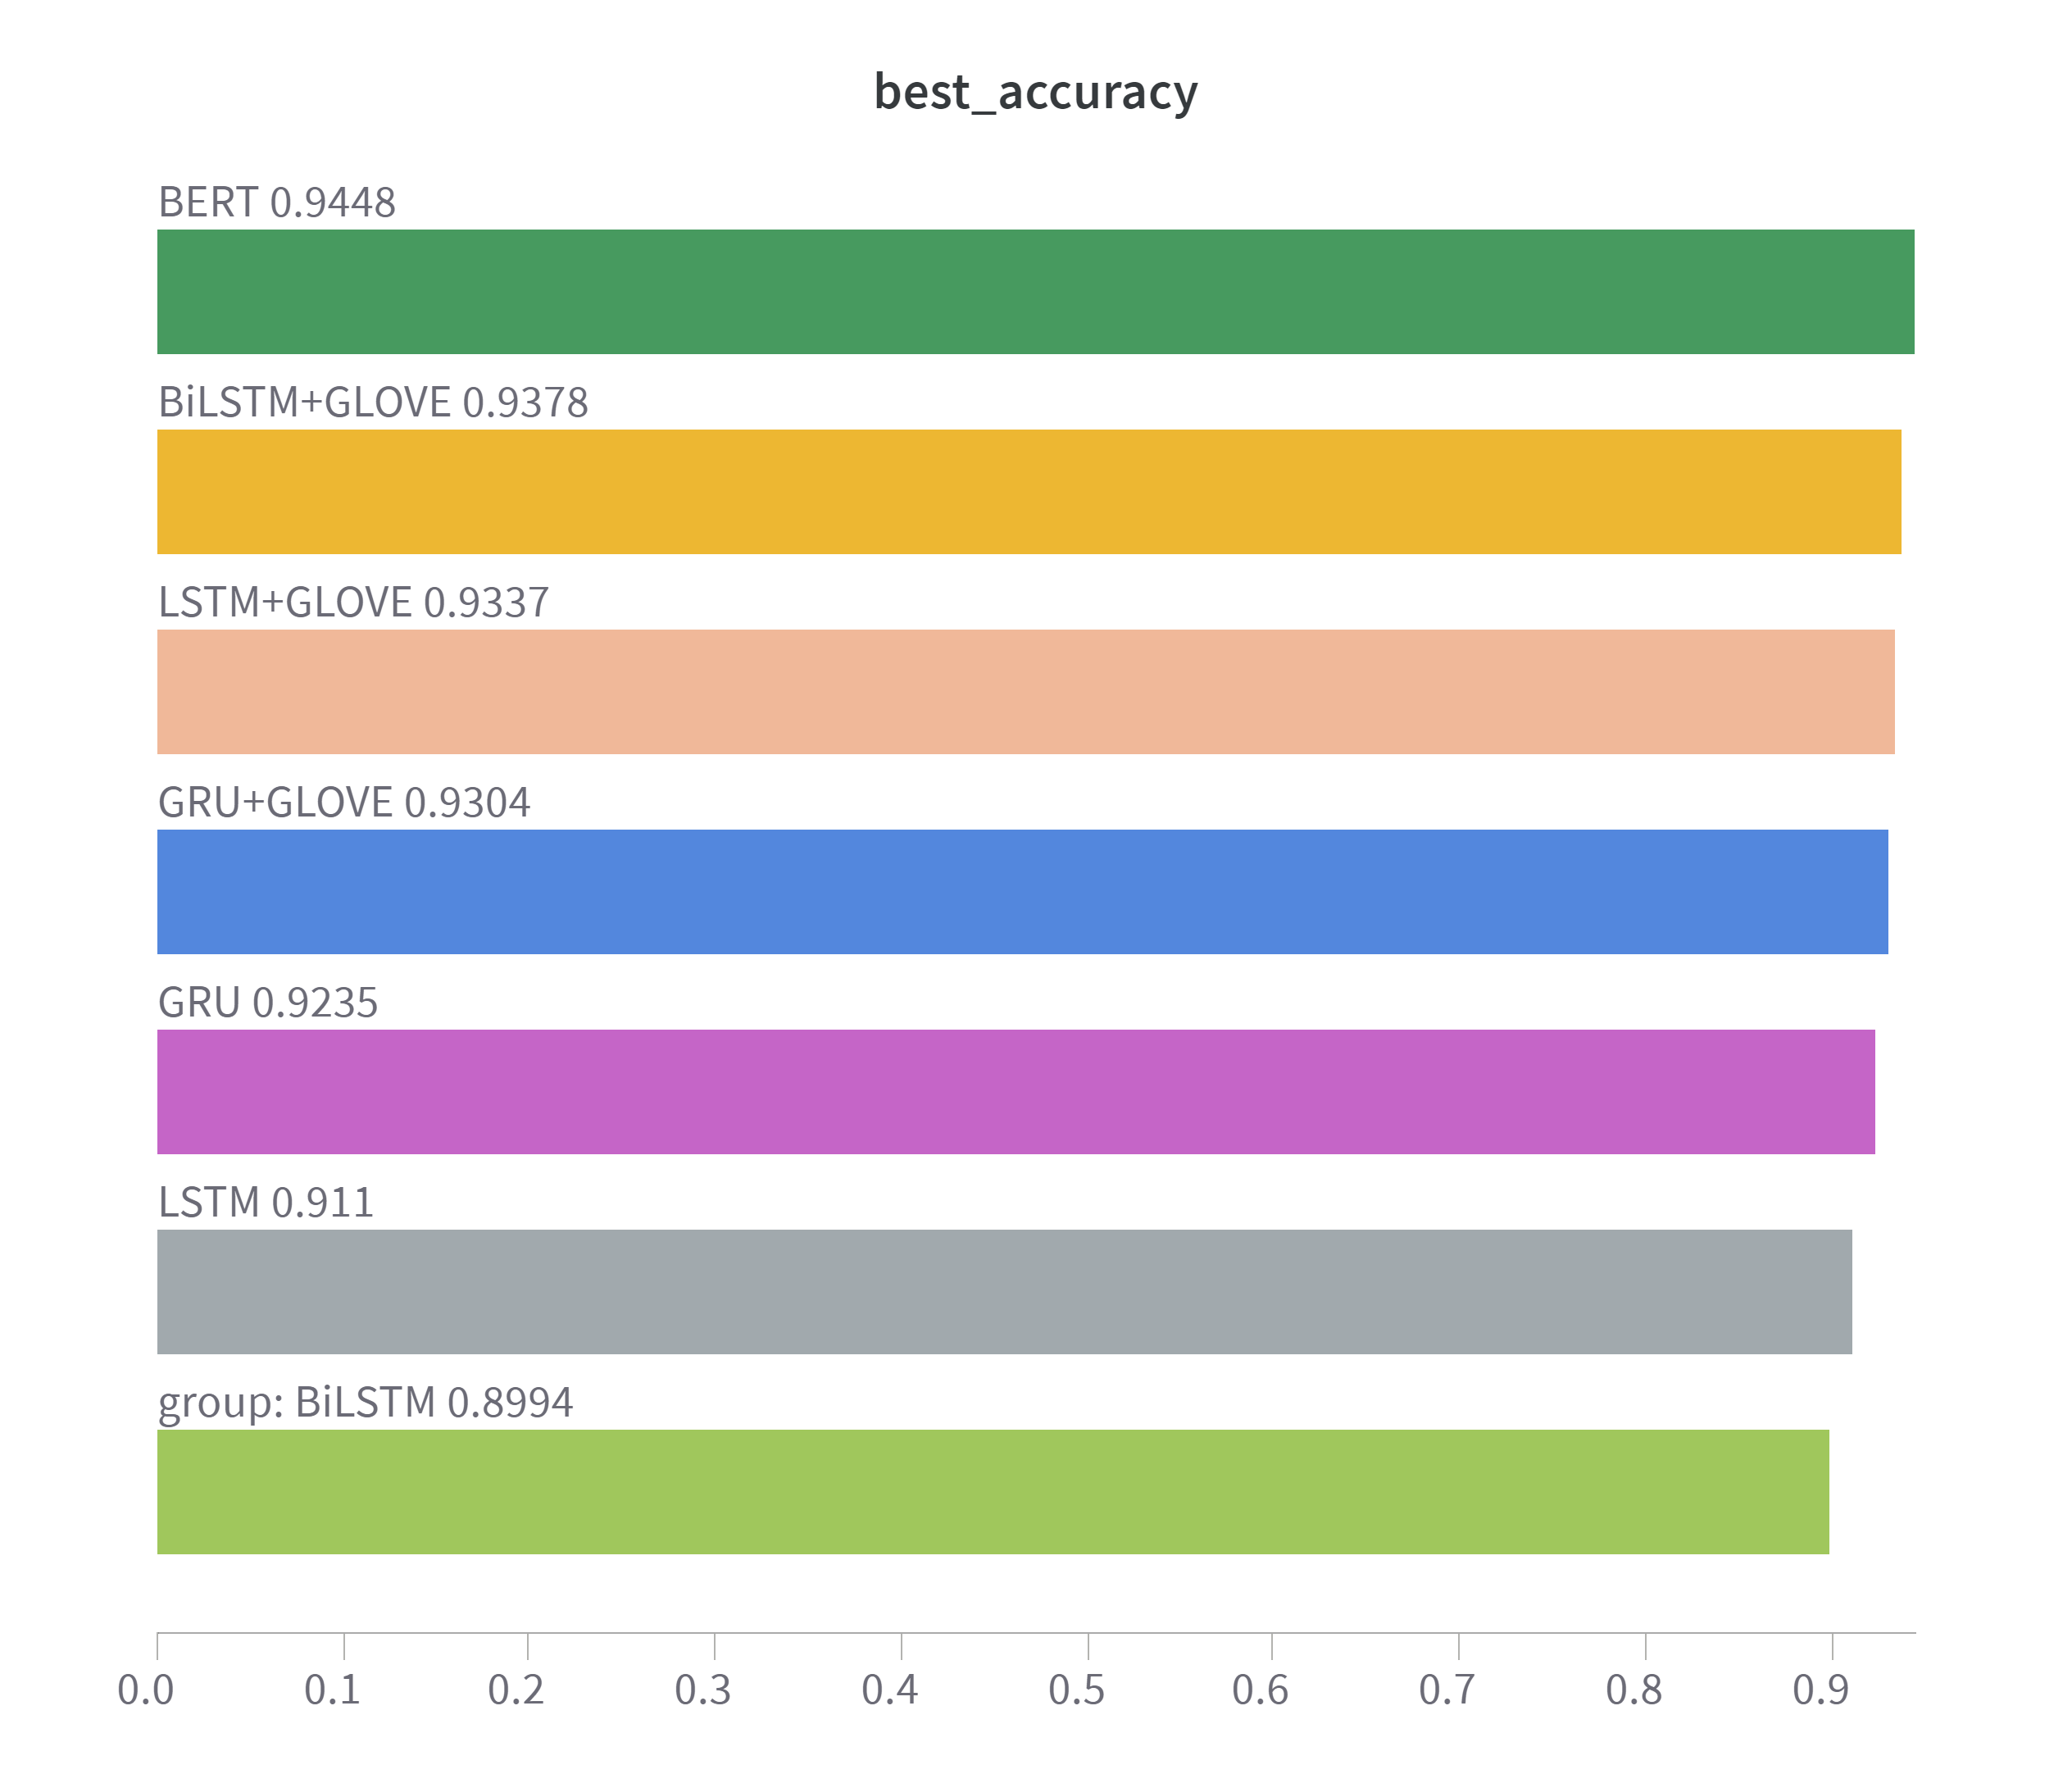

# Confusion Metric

#### BERT

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from io import BytesIO
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
BERT_results = pd.read_csv('predictions_BERT.csv')
BiLSTM_Glove_results = pd.read_csv('predictions_BiLSTM+Glove.csv')
GRU_results = pd.read_csv('predictions_GRU.csv')
GRU_Glove_results = pd.read_csv('predictions_GRU+Glove.csv')
LSTM_results = pd.read_csv('predictions_LSTM.csv')
LSTM_Glove_results = pd.read_csv('predictions_LSTM+Glove.csv')
def confusion_matrix_def(test_result, column1, column2, name1, name2):
    y_true = test_result[column1]
    y_pred = test_result[column2]
    conf_matrix = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    
    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Set up the matplotlib figure for side-by-side plots
    plt.figure(figsize=(30, 12))
    
    # Regular confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', 
                xticklabels=y_true.unique(), yticklabels=y_true.unique(), 
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel(name2)
    plt.ylabel(name1)
    
    # Normalized confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', 
                xticklabels=y_true.unique(), yticklabels=y_true.unique(), 
                cmap='Blues')
    plt.title('Normalized Confusion Matrix')
    plt.xlabel(name2)
    plt.ylabel(name1)
    
    # Main title
    
    # Save the plot to a buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image = Image.open(buffer)
    image_array = np.array(image)
    plt.show()
# accuracy = accuracy_score(BiLSTM_Glove_results["target"], BiLSTM_Glove_results["prediction"])
# accuracy

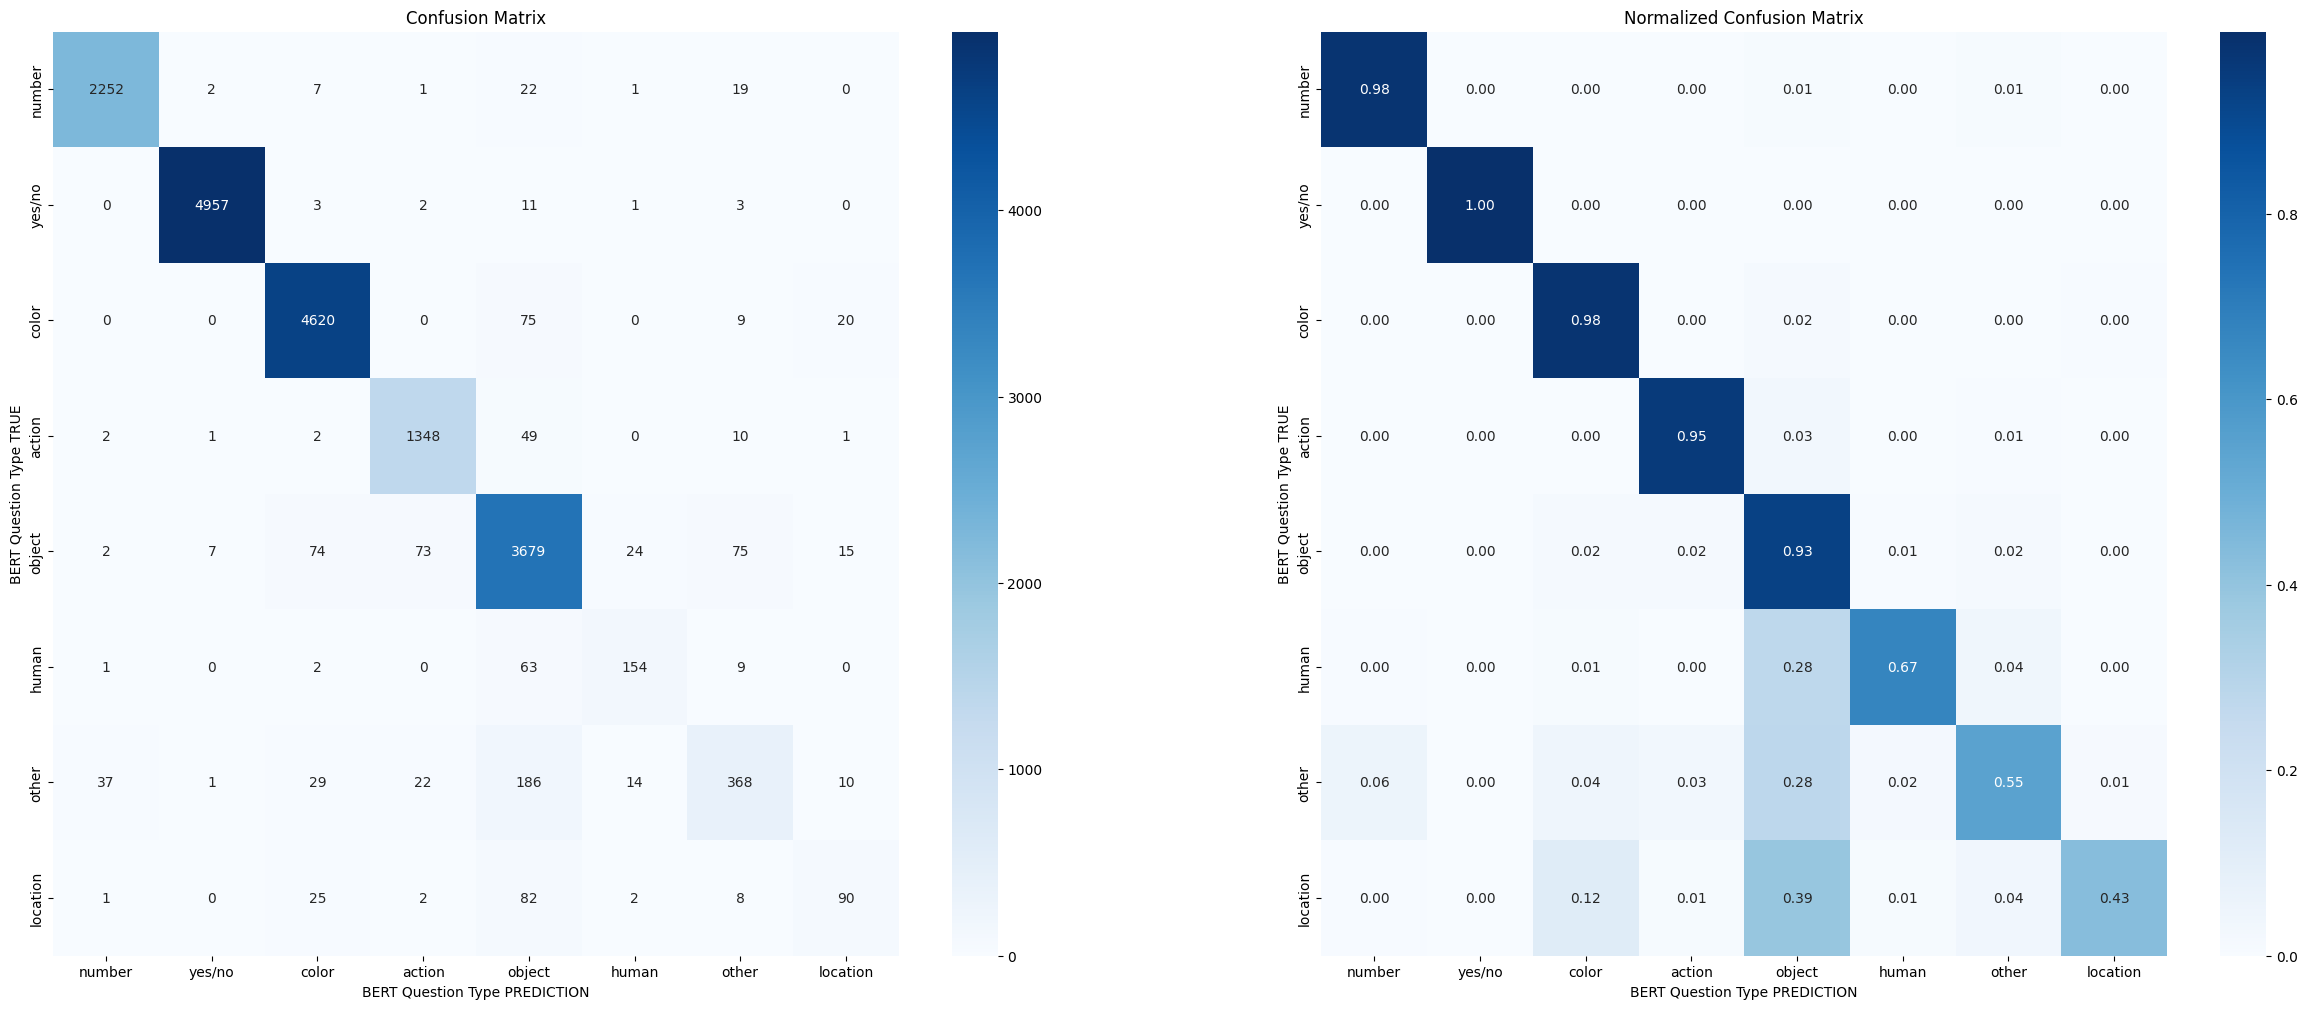

In [43]:
confusion_matrix_def(BERT_results, "target", "prediction", "BERT Question Type TRUE",  "BERT Question Type PREDICTION")

#### VQA Result

In [44]:
vqa_result = pd.read_csv('VQA_result.csv')
vqa_result = vqa_result.rename(columns = {
    "prediction": "vqa_prediction",
    "target": "vqa_target"
})


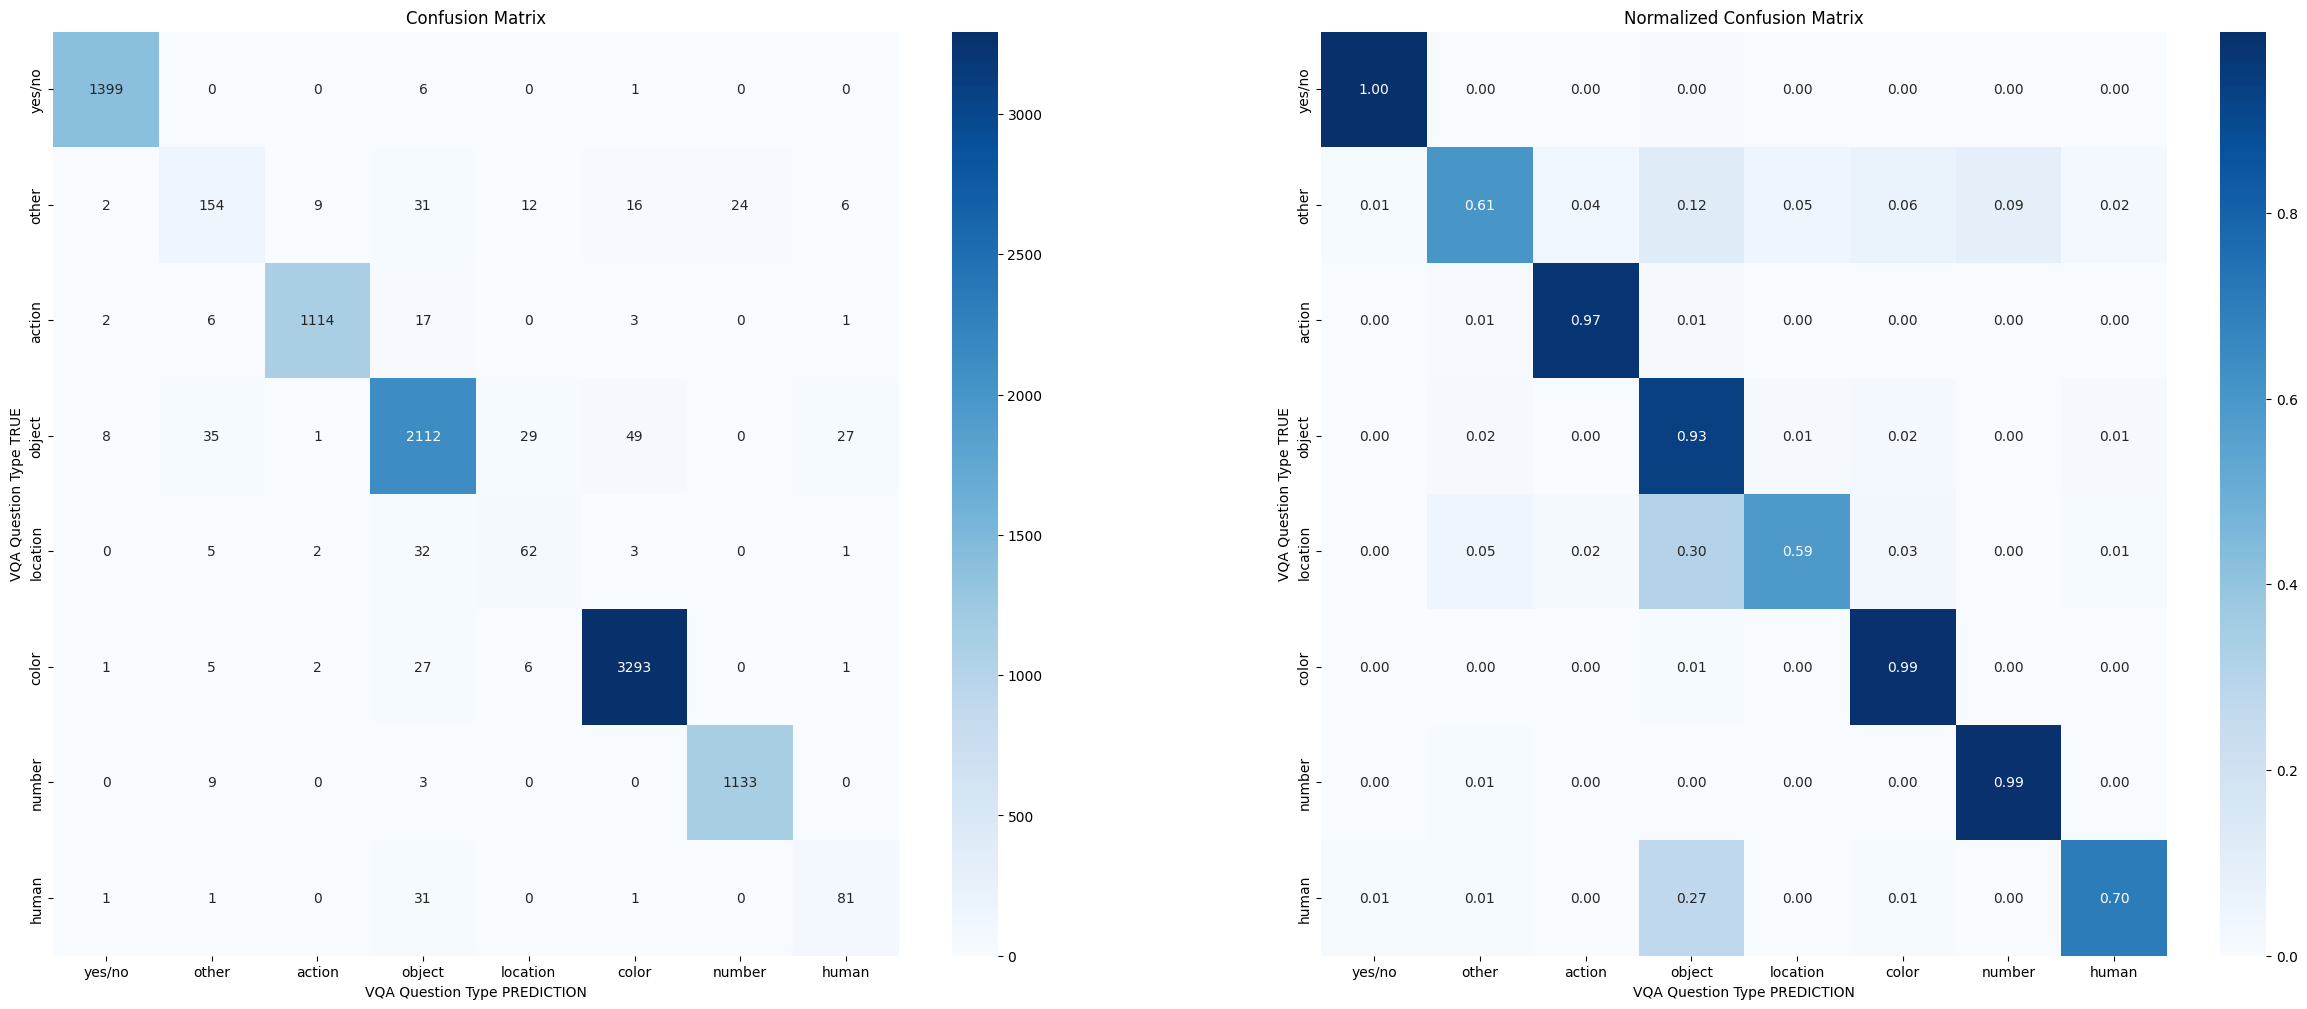

In [45]:
confusion_matrix_def(vqa_result, "small_answer_type_target", "small_answer_type_prediction", "VQA Question Type TRUE",  "VQA Question Type PREDICTION")

#### BERT and VQA Comparison

In [46]:
qt_result = BERT_results
vqa_result = vqa_result.merge(qt_result, on='question_id', how='inner')

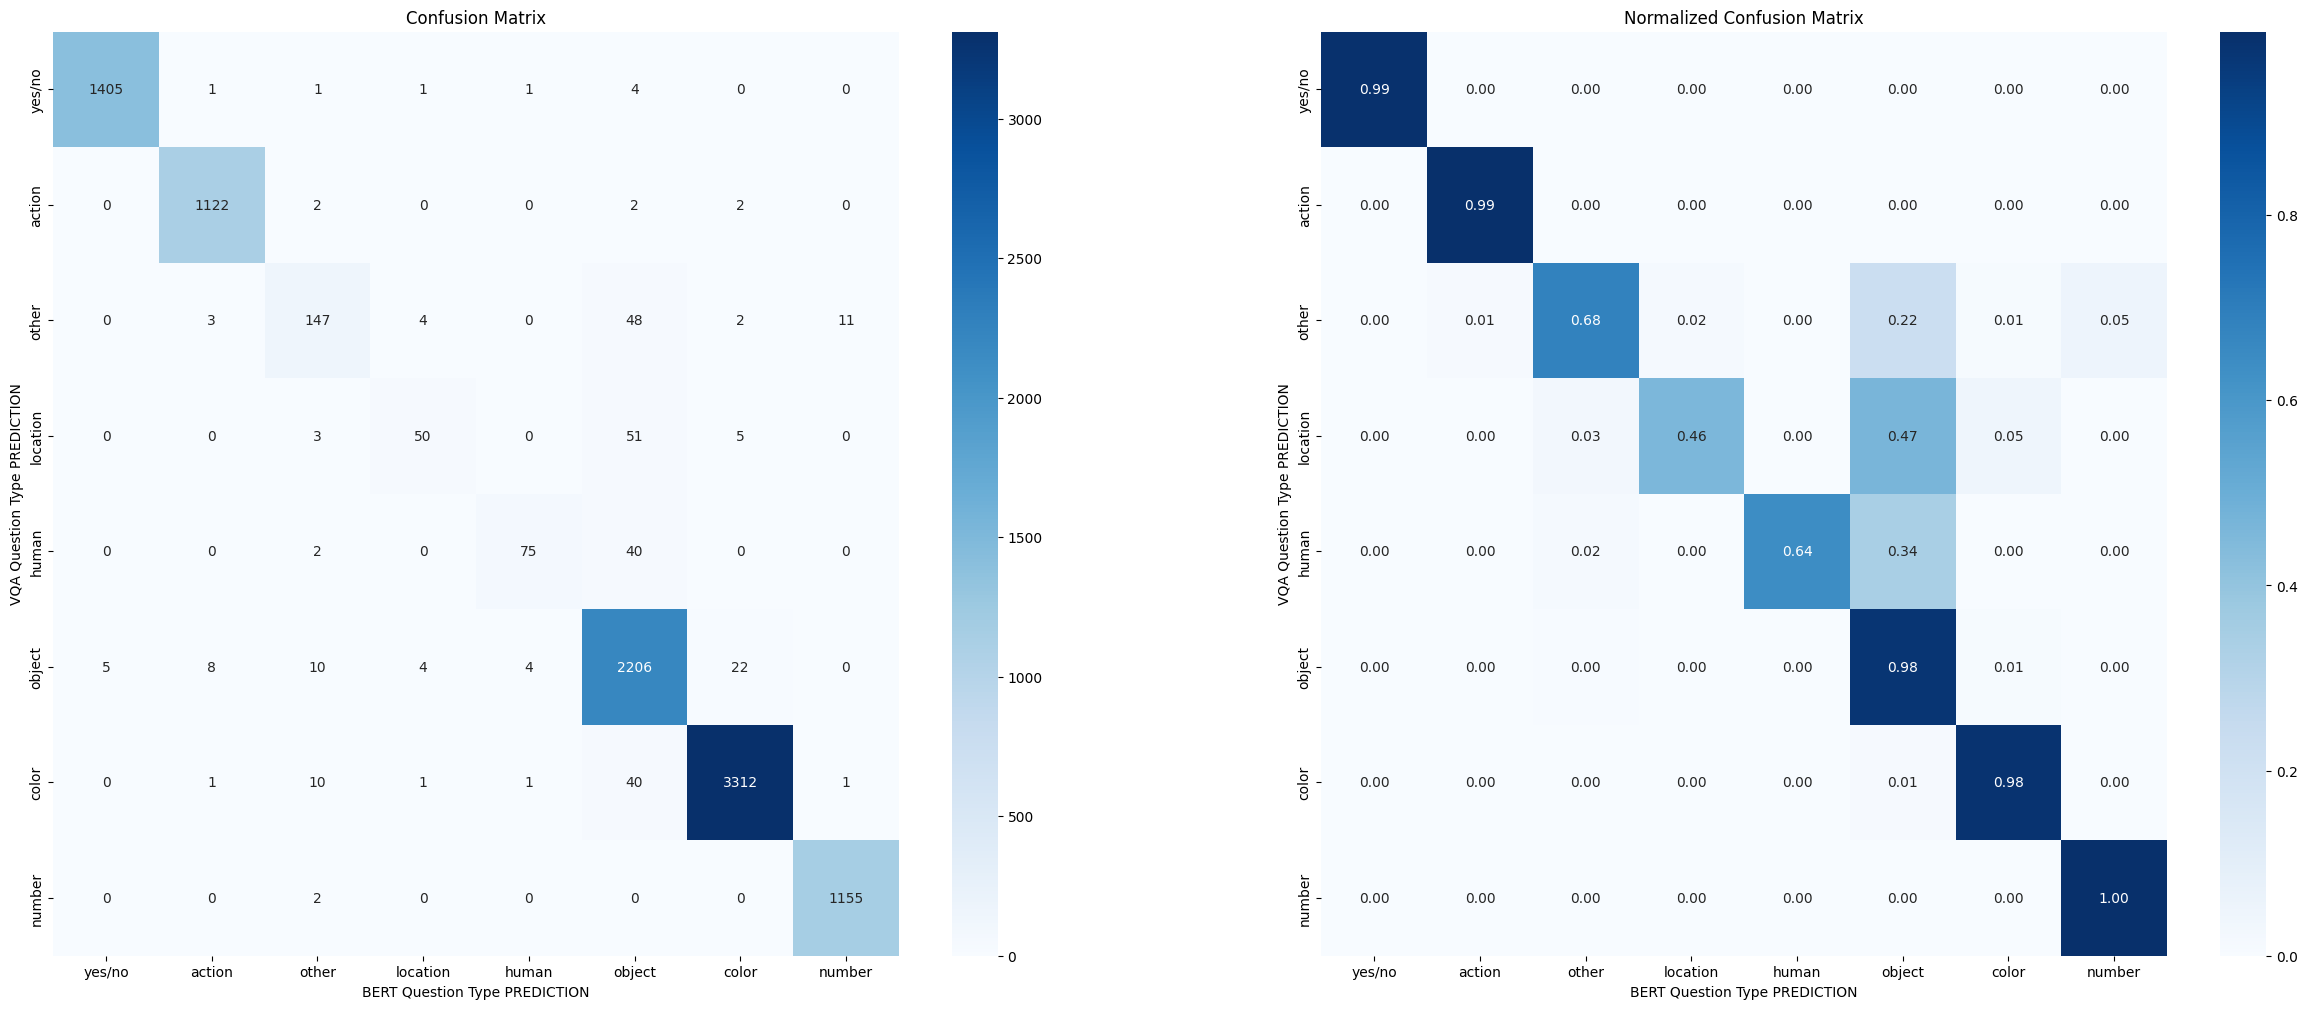

In [47]:
confusion_matrix_def(vqa_result, "small_answer_type_prediction", "prediction", "VQA Question Type PREDICTION",  "BERT Question Type PREDICTION")

In [48]:
vqa_result

,question_id,vqa_prediction,vqa_target,answer_type,small_answer_type_target,small_answer_type_prediction,answer_type_prediction,target,prediction
0,2,yes,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
1,8,yes,yes,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
2,16,no,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
3,28,no,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
4,39,yes,yes,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
...,...,...,...,...,...,...,...,...,...
9759,163657,no,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
9760,165144,no,yes,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
9761,165351,yes,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no
9762,165558,yes,no,yes/no,yes/no,yes/no,yes/no,yes/no,yes/no


In [49]:
accuracy_score(vqa_result["prediction"], vqa_result["small_answer_type_prediction"])

0.9700942236788201

### Bias Analysis

In [65]:
file_paths = ["/home/ndhuynh/data/simpsonsvqa/v1_Annotation_Test_Private_110496_simpsons_vqa.json",
             "/home/ndhuynh/data/simpsonsvqa/v1_Annotation_Train_simpsons_vqa.json",
             "/home/ndhuynh/data/simpsonsvqa/v1_Annotation_Val_simpsons_vqa.json"]

In [66]:
import json
with open("/home/ndhuynh/data/simpsonsvqa/v1_Annotation_Val_simpsons_vqa.json", 'r') as file:
    annotations = json.load(file)["annotations"]
id_to_annotations = {}
for ann in annotations:
    id_to_annotations[ann["id"]] = ann
    
with open("/home/ndhuynh/data/simpsonsvqa/v1_Question_Val_simpsons_vqa.json", 'r') as file:
    questions = json.load(file)["questions"]
id_to_questions = {}
for ques in questions:
    id_to_questions[ques["id"]] = ques

In [67]:
BERT_results["vqa answer"] = BERT_results["question_id"].apply(lambda x: id_to_annotations[x]["answer"])
BERT_results["question"] = BERT_results["question_id"].apply(lambda x: id_to_questions[x]["question"])

In [68]:
wrong_answers = BERT_results[BERT_results["prediction"] != BERT_results["target"]]

In [69]:
wrong_list = []
for question_type in wrong_answers["target"].unique():
    print(f"||  TARGET  | PREDICTION ||                                   TOP QUESTIONS                              | VQA ANSWERS   | COUNT ||")
    print("___________________________________________________________________________________________________________________________________")
    wrong_answers_qt = wrong_answers[wrong_answers['target'] == question_type]
    vc_wrong_answers_qt = wrong_answers_qt['prediction'].value_counts().reset_index()
    for row_qt in vc_wrong_answers_qt.to_dict("records"):
        wrong_answers_qt_i = wrong_answers_qt[wrong_answers_qt["prediction"] == row_qt["prediction"]]
        wrong_answers_qt_ques = wrong_answers_qt_i["question"].value_counts().reset_index()["question"].to_list()
        for question_i in wrong_answers_qt_ques:
            wrong_answers_qt_i_j = wrong_answers_qt_i[wrong_answers_qt_i["question"] == question_i]
            wrong_answers_qt_i_j_answer = wrong_answers_qt_i_j["vqa answer"].value_counts().reset_index().to_dict("records")
            for answer_i in wrong_answers_qt_i_j_answer:
                print(f"||{question_type.upper().ljust(10)}| {row_qt['prediction'].upper().ljust(12)}|| {question_i.ljust(75) } |{answer_i['vqa answer'].ljust(15)}|{str(answer_i['count']).ljust(7)}||")
                wrong_list.append({
                    "target": question_type,
                    "prediction": row_qt['prediction'],
                    "question": question_i,
                    "answer": answer_i['vqa answer'],
                    "count":answer_i['count']
                })
        if len(wrong_answers_qt_ques) >0:
            print("___________________________________________________________________________________________________________________________________")

||  TARGET  | PREDICTION ||                                   TOP QUESTIONS                              | VQA ANSWERS   | COUNT ||
___________________________________________________________________________________________________________________________________
||OBJECT    | OTHER       || what shape is the plate?                                                    |square         |1      ||
||OBJECT    | OTHER       || what shape is the plate?                                                    |circle         |1      ||
||OBJECT    | OTHER       || where is the man skiing?                                                    |mountain       |1      ||
||OBJECT    | OTHER       || where is the man skiing?                                                    |road           |1      ||
||OBJECT    | OTHER       || what is the shape of the door?                                              |rectangle      |2      ||
||OBJECT    | OTHER       || what mode of transportation is he using?       

In [70]:
wrong_csv = pd.DataFrame(wrong_list)
wrong_csv.to_csv("wrong_prediction.csv", index = True)

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wordcount(data, qt_value, wrong_qt):
    combined_text_question = " ".join(data["question"].tolist())
    combined_text_answer = " ".join(data["answer"].tolist())
    wordcloud_question = WordCloud(width=400, height=400, background_color='white').generate(combined_text_question)
    wordcloud_answer = WordCloud(width=400, height=400, background_color='white').generate(combined_text_answer)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].text(0.5, 0.5, f'True Target: {qt_value}\nPrediction: {wrong_qt}', fontsize=20, ha='center', va='center')
    axs[0].axis("off")
    axs[1].imshow(wordcloud_question)
    axs[1].set_title('Word Cloud for Questions')
    axs[1].axis("off")
    axs[2].imshow(wordcloud_answer)
    axs[2].set_title('Word Cloud for Answers')
    axs[2].axis("off")
    plt.subplots_adjust(wspace=0.4)
    plt.show()

In [72]:
# for qt_value in wrong_csv["target"].unique():
#     wrong_csv_i = wrong_csv[wrong_csv["target"] == qt_value]
#     for wrong_qt in wrong_csv["prediction"].unique():
#         wrong_csv_i_j = wrong_csv_i[wrong_csv_i["prediction"] == wrong_qt]
#         try:
#             wordcount(wrong_csv_i_j, qt_value, wrong_qt)
#             print(wrong_csv_i_j["question"].unique())
#         except:
#             pass

In [73]:
full_dataset = pd.DataFrame(annotations)[["id", "topic", "answer"]]

In [74]:
full_dataset["question"] = full_dataset["id"].apply(lambda x: id_to_questions[x]["question"])

In [75]:
full_dataset = full_dataset[["id", "question", "topic", "answer"]]

In [76]:
with open("../super_answer_type_simpsons.json", 'r') as file:
    super_type = json.load(file)

In [77]:
full_dataset["answer_type"] = full_dataset["answer"].map(super_type)

In [78]:
full_dataset

,id,question,topic,answer,answer_type
0,2,are all of the people in the crowd wearing the...,comparative,no,yes/no
1,6,are all of them holding phones?,comparative,yes,yes/no
2,8,are all people on the table looking up?,comparative,yes,yes/no
3,10,are all people wearing glasses?,attribute classification,yes,yes/no
4,11,are all people wearing gloves?,comparative,no,yes/no
...,...,...,...,...,...
21944,166547,how many cars are there?,counting,3,number
21945,166548,how many tents are in this image?,counting,1,number
21946,166552,what is the color of the bananas?,attribute classification,yellow,color
21947,166553,what color is the bottom of the boat?,attribute classification,blue,color


In [79]:
full_dataset[full_dataset["answer"] == "right"]

,id,question,topic,answer,answer_type
297,1092,are the people on the right or left side of th...,spatial,right,color
2517,24669,is the person on the left or right side of the...,spatial,right,color
2593,25839,is the table on the left or right side?,spatial,right,color
7398,66718,what hand is holding the paper?,spatial,right,color
12209,101147,where are the bags?,spatial,right,color
...,...,...,...,...,...
20369,155898,what hand is she holding the scissors with?,spatial,right,color
20576,157182,what arm is the batter swinging with?,spatial,right,color
20726,158250,"according to the signs, which side is number 2?",spatial,right,color
21038,160617,what hand is the man holding the tennis racque...,spatial,right,color


In [80]:
full_dataset[full_dataset["answer"].isin(["square", "circle"])]

,id,question,topic,answer,answer_type
12810,105443,what is the shape of the plate?,attribute classification,square,object
13499,110035,where is the little girl walking?,spatial,square,object
13513,110084,is the door on the building square or round on...,spatial,square,object
13633,110927,what shape is the plate?,attribute classification,circle,object
16576,130513,what shape is the plate?,attribute classification,square,object
16663,131157,what is the red thing on the white page?,object recognition,circle,object
17165,134183,what shape are most of the pastries?,attribute classification,square,object
17280,135080,what shape are the dark tiles arranged in?,spatial,square,object
17439,136605,what shape is the mirror?,attribute classification,square,object
17528,136973,what shape is the door?,attribute classification,square,object


In [81]:
full_dataset[full_dataset["question"].str.contains("shape")]["answer"].value_counts()

answer
round          16
rectangle      14
square          9
oval            5
rectangular     5
large           3
blue            2
star            2
octagon         2
brick           2
long            2
big             1
bowl            1
straight        1
mirror          1
no              1
diamond         1
cross           1
bow             1
hand            1
bat             1
banana          1
heart           1
window          1
circle          1
glass           1
duck            1
woman           1
wooden          1
tiles           1
yes             1
Name: count, dtype: int64

In [82]:
full_dataset[full_dataset["answer"].isin(["restaurant"])]

,id,question,topic,answer,answer_type
12647,104400,where is the picture taken?,spatial,restaurant,object
15266,121638,what type of place is this?,attribute classification,restaurant,object
16769,131789,where is the white awning?,spatial,restaurant,object
16789,131930,"is this picture taken, probably, in a home or ...",spatial,restaurant,object
18407,142847,where is this oven located?,spatial,restaurant,object
19471,150160,is this a restaurant or home and which curry ...,attribute classification,restaurant,object
21439,163365,is this a house or a restaurant?,object recognition,restaurant,object
21728,165177,where is this location?,spatial,restaurant,object


In [83]:
full_dataset[full_dataset["answer"].isin(["mountain"])]

,id,question,topic,answer,answer_type
296,1091,are the people on the mountain or in a building?,spatial,mountain,object
7652,68634,what is behind the people?,object recognition,mountain,object
8035,71541,what is in the background?,object recognition,mountain,object
8047,71572,what is in the background?,spatial,mountain,object
8080,71737,what is in the background?,object recognition,mountain,object
8218,72469,what is in the background?,object recognition,mountain,object
8230,72544,what is in the background?,object recognition,mountain,object
8240,72611,what is in the background?,object recognition,mountain,object
8268,72831,what is in the background?,spatial,mountain,object
8288,72989,what is in the background?,object recognition,mountain,object


In [86]:
full_dataset[full_dataset["answer"].isin(["road"])]

,id,question,topic,answer,answer_type
8060,71655,what is in the background?,object recognition,road,object
8373,73602,what is in the foreground?,spatial,road,object
8847,77112,what is on the right side of the street?,object recognition,road,object
11732,97820,what is the setting in the image?,attribute classification,road,object
12278,101623,where are the people standing?,spatial,road,object
12284,101659,where are the people standing?,spatial,road,object
12341,102094,where is the building located?,spatial,road,object
12383,102466,where is the man standing?,spatial,road,object
12387,102502,where is the man standing?,spatial,road,object
12389,102521,where is the man standing?,spatial,road,object


In [56]:
full_dataset[full_dataset["question"].str.contains("made of")][["answer","answer_type"]].value_counts()

answer     answer_type
wood       color          96
metal      object         33
brick      color          18
yes        yes/no         13
glass      object         12
tiles      object          6
no         yes/no          6
dirt       object          5
stone      object          3
plastic    object          2
wooden     color           2
concrete   object          2
fabric     object          2
silver     color           1
2          number          1
oak        object          1
basket     object          1
granite    object          1
cloth      object          1
chocolate  object          1
ceramic    object          1
leather    object          1
Name: count, dtype: int64

In [88]:
full_dataset[full_dataset["answer"].isin(["baseball"])]

,id,question,topic,answer,answer_type
3655,36915,what are the children playing?,action recognition,baseball,object
7395,66710,what game are they playing?,reasoning,baseball,object
7396,66711,what game are they watching?,object recognition,baseball,object
7397,66712,what game can be played on the baseball field?,attribute classification,baseball,object
7900,70608,what is in front of the person's hands?,spatial,baseball,object
11444,95826,what is the person holding?,object recognition,baseball,object
12129,100736,what sport is being played in the picture?,object recognition,baseball,object
12130,100741,what sport might this person play?,reasoning,baseball,object
12824,105549,what sport is being played?,action recognition,baseball,object
13001,106767,what sport is being played?,action recognition,baseball,object


In [103]:
full_dataset[(full_dataset["question"].str.contains("sport")) 
            | full_dataset["question"].str.contains("playing")
            | full_dataset["question"].str.contains("played")][["answer"]].value_counts()[:50]

answer       
baseball         46
tennis           33
yes              20
frisbee          17
no               16
soccer           10
train             6
surfing           5
snowboarding      5
skiing            5
skateboarding     5
saxophone         5
skateboard        4
2                 4
1                 3
guitar            3
bowling           3
car               2
3                 2
surfboard         2
bicycle           2
boat              2
bus               2
pitcher           2
home              1
motorcycle        1
website           1
female            1
5                 1
6                 1
floor             1
apples            1
ball              1
skis              1
dog               1
bike              1
game              1
green             1
public            1
plane             1
english           1
people            1
nothing           1
none              1
group             1
donut             1
Name: count, dtype: int64

In [130]:
full_dataset[full_dataset["answer"].isin(["top"])]

,id,question,topic,answer,answer_type
16486,129826,what part of the fence is broken?,attribute classification,top,other
